# COGS 108 - Final Project 

# Overview

This project investigates whether nearby restaurants in North Carolina share similar sanitary conditions and whether such similarities are caused by the socio-economic conditions of the restaurants' area. The underlying data did not follow any clear distributions, so the methods for analysis were mostly non-parametric (K-Nearest Neighbors and Mann Whitney U). The Results demonstrated that while nearby restaurants did share similar sanitary conditions, the socio-economic conditions of the areas did not significantly impact these similarities. However, the significance of the conclusions was slightly compromised due to the data being very skewed and having very little variance.

### Name & PID

- Name: Carlos Eduardo Matos Ribeiro
- PID: A14032489

# Research Question

Do nearby restaurants (same city, ZIP code, or similar coordinates) in North Carolina share similar sanitary conditions (inspection scores and number of critical violations)? Are such trends caused by the socioeconomic conditions (i.e income per capita) of said restaurants' area?

## Background and Prior Work

In North Carolina, restaurants and other food establishments are inspected by local county professionals between one and four times annually$^{1}$. In these inspections, violations are counted and tabulated, each with its own point value depending on its severity; the points are then subtracted from 100 to give a restaurant's final score, which is then used to determine its letter grade$^{1}$. This simple system allows for a straightforward way to quantify the sanitary conditions of restaurants, making it possible to carry out data analyses to investigate general trends and determining factors of said conditions.

With that in mind, I have decided to investigate whether the sanitary conditions of restaurants in North Carolina are related to their location, and more specifically if said locations' socio-economic condition have a considerable impact in this relationship. Certain characteristics about neighborhoods, including how busy it is and the average spending potential of its residents and by passers can greatly affect key factors for a restaurant's success, including the amount of customers it can expect to have and the amount of revenue that it can generate. Customer traffic and revenue in turn can affect many factors related to sanitary conditions, including: how much staff a restaurant can hire (and how overworked said staff is), how well trained the staff is, the quality of the equipment, the quality of the produce, how often produce has to be restocked, how  much attention managers can devote to health and safety practices, etc. Therefore, it is reasonable to expect that the socio-economic conditions of a restaurant's area will somehow affect its health and safety conditions.

The most relevant research related to my investigation was a study conducted by the Environmental Health Specialists Network, based on several US states, which aimed to identify which factors most impacted safe food preparation practices in a restaurant. The study concluded that some of the main factors were the time pressure the employees felt, the quality of their equipment, the resources they had available and the emphasis managers gave to food safety$^{2}$. As discussed in the previous paragraph, many of these factors can be impacted by a restaurant's location and its socio-economic conditions, so this study helps corroborate that my research question holds promise and is worth investigating.


References:
- 1) https://www.forsyth.cc/PublicHealth/EnvironmentalHealth/aboutInspections.aspx
- 2) https://www.cdc.gov/nceh/ehs/ehsnet/docs/Factors_Impacting_Food_Workers_Food_Prep_FPT_journal.pdf

# Hypothesis


I expect that there will be patterns in the sanitary conditions of restaurants in North Carolina that are close to each other. Additionally, I expect that there will be a positive relationship between the socio-economic characteristics of a restaurant's location, and its overall sanitary conditions, with restaurants in wealthier neighborhoods having fewer health/safety violations then restaurants in low-income, emptier neighborhoods. The reason for that premise was hinted at in the previous section: restaurants in wealthier neighborhoods are more likely to have a constant influx of customers with sufficient spending power to drive their business, thus have the ability to have an adequately-sized staff that is properly trained and equipped to maintain appropriate health conditions. Conversely, restaurants in low-income neighborhoods are less likely to have sufficient customers/revenue to adequately train and equip their staff, and it might face financial hardships that would lead it to overlook sanitary issues.

# Dataset(s)

- Dataset Name: Inspections
- Link to the dataset: data/inspections.csv
- Number of observations: 18466
 
In this dataset, each row is a restaurant inspection and each column holds information either about the specific inspection, or the restaurant being inspected. For each inspection there is a myriad of information, including the restaurant's name, address, zip code, coordinate location, the inspection date, number of critical/non-critical violation and overall score, to name a few.

- Dataset Name: Zip
- Link to the dataset: data/zip.csv
- Number of observations: 38

This dataset gathers general socio-economic indicators for various zip codes in North Carolina. Each row is a specific zip code and each column is a different indicator, such as per capita income, median family income and the percent of families living below the poverty line.

The datasets can be combined via the zip codes, with the Zip dataset being used to identify the socio-economic indicators of the neighborhood of each particular inspection.

# Setup

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error 
from scipy.stats import mannwhitneyu

# Data Cleaning

First I loaded and examined the inspections dataset:

In [2]:
df_inspections = pd.read_csv('data/inspections.csv')
print(df_inspections.columns)
df_inspections.head()

Index(['hsisid', 'date', 'name', 'address1', 'address2', 'city', 'state',
       'postalcode', 'phonenumber', 'restaurantopendate',
       'days_from_open_date', 'facilitytype', 'x', 'y', 'geocodestatus', 'zip',
       'type', 'description', 'inspectedby', 'inspection_num', 'inspector_id',
       'previous_inspection_date', 'days_since_previous_inspection',
       'previous_inspection_by_same_inspector', 'score', 'num_critical',
       'num_non_critical', 'num_critical_previous',
       'num_non_critical_previous', 'num_critical_mean_previous',
       'num_non_critical_mean_previous', 'avg_neighbor_num_critical',
       'avg_neighbor_num_non_critical', 'top_match', 'second_match',
       'critical'],
      dtype='object')


,hsisid,date,name,address1,address2,city,state,postalcode,phonenumber,restaurantopendate,...,num_non_critical,num_critical_previous,num_non_critical_previous,num_critical_mean_previous,num_non_critical_mean_previous,avg_neighbor_num_critical,avg_neighbor_num_non_critical,top_match,second_match,critical
0,4092013748,2012-09-21T00:00:00Z,Cafe 3000 At Wake Med,3000 New Bern Ave,NaN,raleigh,NC,27610,(919) 350-8047,2002-12-21T00:00:00Z,...,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,4092014046,2012-09-21T00:00:00Z,Overtime Sports Pub,1030-149 N Rogers Ln,NaN,raleigh,NC,27610,(919) 255-9556,2004-05-04T00:00:00Z,...,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,4092015191,2012-09-21T00:00:00Z,TASTE OF CHINA,6209 ROCK QUARRY RD,STE 126,raleigh,NC,27610,(919) 773-2285,2008-08-04T00:00:00Z,...,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,4092016122,2012-09-21T00:00:00Z,Panera Bread #1643,1065 Darrington DR,NaN,cary,NC,27513,NaN,2012-03-28T00:00:00Z,...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,4092021513,2012-09-21T00:00:00Z,WalMart Supercenter #4499-00 Deli/Bakery,841 E Gannon AVE,NaN,zebulon,NC,27597,(919) 269-2221 ext. 304,2008-02-25T00:00:00Z,...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


Clearly there are several columns that are not needed for my analysis, some of which have some unnecessary personal information (more on this later in the ethics & privacy section), so the first step was to narrow it down to the potentially relevant columns, including city, zip, coordinates, overall sanitary score and number of each type (critical/non-critical) of violation.

In [3]:
df_inspections = df_inspections[['hsisid','city','zip','score','num_critical','num_non_critical','x','y','geocodestatus',]]

Next I ensured that, within the relevant columns, there was no null data to worry about:

In [4]:
pd.isna(df_inspections).any().any()


False

Finally, I decided to add a column with each restaurant's letter grade (A >= 90, B >= 80, C >= 70), since they usually are the main takeaway from each inspection and could later be useful for analysis.

In [5]:
# First define a function for the transformation
def to_letter_grade(score):
    if score >= 90:
        return 'A'
    if score >= 80:
        return 'B'
    # Min score in dataset was 72
    else:
        return 'C'
    
# Then apply function and assign to new column
df_inspections['grade'] = df_inspections['score'].apply(to_letter_grade)

# Reorder columns to keep grade near score so its meaning is more clear
df_inspections = df_inspections[['hsisid','city','zip','score','grade','num_critical','num_non_critical','x','y','geocodestatus',]]

Then, I loaded and inspected the zip dataset

In [6]:
df_zipcodes = pd.read_csv('data/zipcodes.csv')
print(df_zipcodes.columns)
df_zipcodes.head()

Index(['zip', 'median_family_income_dollars',
       'median_household_income_dollars', 'per_capita_income_dollars',
       'percent_damilies_below_poverty_line', 'percent_snap_benefits',
       'percent_supplemental_security_income', 'percent_nonwhite'],
      dtype='object')


,zip,median_family_income_dollars,median_household_income_dollars,per_capita_income_dollars,percent_damilies_below_poverty_line,percent_snap_benefits,percent_supplemental_security_income,percent_nonwhite
0,27501,59408,51121,21631,10.5,15.5,5.2,17.9
1,27502,109891,95857,36763,3.4,2.4,0.8,18.9
2,27511,82292,67392,33139,9.6,4.5,2.2,24.8
3,27513,109736,87262,41232,3.8,2.4,1.5,27.8
4,27518,125432,98247,49865,5.5,1.0,1.7,19.9


Observing the columns, I noticed that some had information that was either unnecessary, redundant, and/or problematic (more on the ethics and privacy section), so there were all removed. The remaining columns were all somehow related, so for simplicity I decided to keep only income per capita. Finally, I ensured that there was no null data to worry about.

In [7]:
df_zipcodes = df_zipcodes.rename(columns={"percent_damilies_below_poverty_line": "percent_families_below_poverty_line"})
df_zipcodes = df_zipcodes[['zip','per_capita_income_dollars']]
pd.isna(df_zipcodes).any().any()

False

With both datasets in structured, tidy, format, streamlined to keep only potentially relevant information, and free of null values, they were both ready for analysis and no further cleaning was required.

# Data Analysis & Results

### Analysis preamble

Back in the datasets portion, I noticed that the two datasets that I am using are very unbalanced in terms of size, since one has around 18000 observations and the other only 38. Before analyzing the data, I thought it was prudent to better understand that disparity by looking closer to the information that they shared.

In [8]:
insp_zips = df_inspections['zip'].unique()
zips = df_zipcodes['zip'].unique()
print("Zips in inspections dataset %d" %len(insp_zips))
print("Zips in zipcodes dataset %d" %len(zips))
count = 0
for elem in insp_zips:
    if elem in zips:
        count += 1
print("Zips shared by both datasets %d" %count)

Zips in inspections dataset 51
Zips in zipcodes dataset 38
Zips shared by both datasets 37


As shown above, the disparity in number of observations between the datasets is not very problematic, since the inspection dataset does not have that many unique zip codes, and many of them are shared between both data sets. However, it is still likely that many observations in the inspection datasets will not have corresponding information in the zip codes dataset. 

With that in mind, I decided to break my analysis into different parts. First, I will use only the inspection dataset to examine whether restaurants that are close to each other share similar sanitary conditions. Then, I will combine the datasets, keeping only the data from zip codes shared by both, to analyze to what extent said location trends can be explained by the available socio-economic indicators.

### Distribution of grades, scores and violations

Firstly, lets take a look at the general distribution of scores and grades of all the restaurants in the dataset

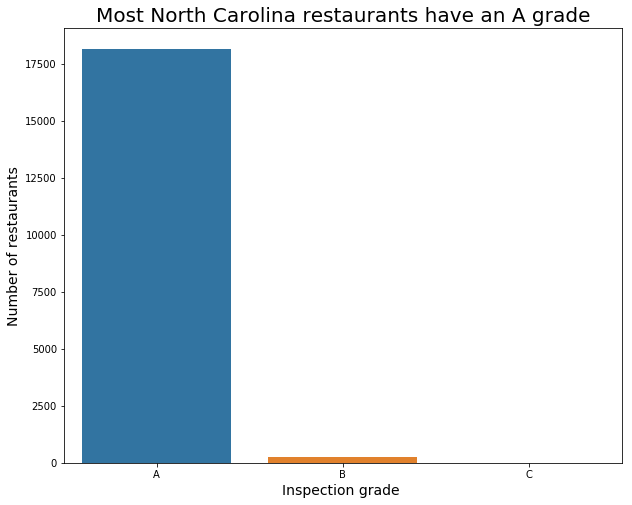

In [9]:
plt.figure(figsize=(10, 8))
graph = sns.countplot(x='grade',data=df_inspections)
graph.set_title("Most North Carolina restaurants have an A grade",fontsize=20)
graph.set_xlabel("Inspection grade ",fontsize=14);
graph.set_ylabel("Number of restaurants",fontsize=14)
plt.show()

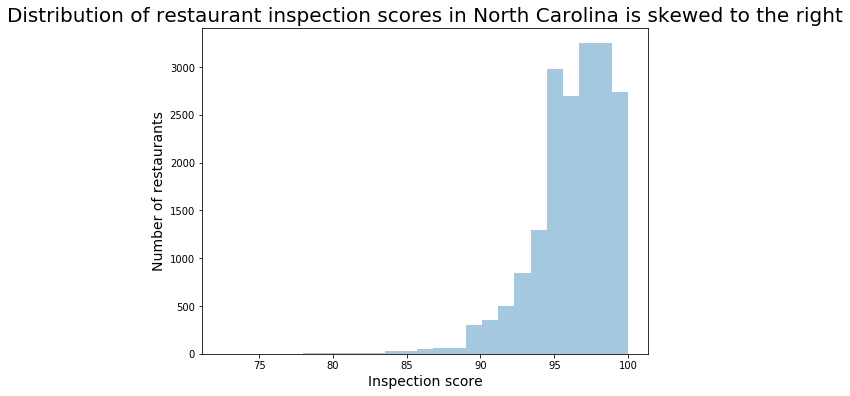

In [10]:
plt.figure(figsize=(8, 6))
graph = sns.distplot(df_inspections['score'], bins=25, kde=False);
graph.set_title("Distribution of restaurant inspection scores in North Carolina is skewed to the right",fontsize=20)
graph.set_xlabel("Inspection score",fontsize=14);
graph.set_ylabel("Number of restaurants",fontsize=14)
plt.show()

From the graphs above we can observe that the distribution is very skewed ($\textbf{not normally distributed}$), with the vast majority of restaurants in our dataset in the A range, and the median being around 95. The scores being so high and generally close together is rather discouraging for analysis, since it is harder to investigate factors that impact scores when all of the scores are so similar. For the same reason, the letter grades are even less informative, since virtually every restaurant has an A.

Therefore, let's use more histograms to examine the distribution of other metrics for health/safety conditions: the number of critical/non-critical violations

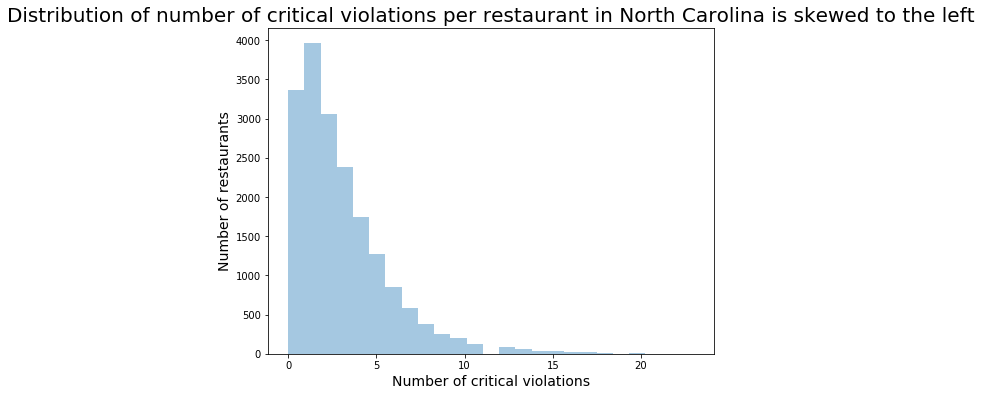

In [11]:
plt.figure(figsize=(8, 6))
graph = sns.distplot(df_inspections['num_critical'], bins=25, kde=False);
graph.set_title("Distribution of number of critical violations per restaurant in North Carolina is skewed to the left",fontsize=20)
graph.set_xlabel("Number of critical violations",fontsize=14);
graph.set_ylabel("Number of restaurants",fontsize=14)
plt.show()

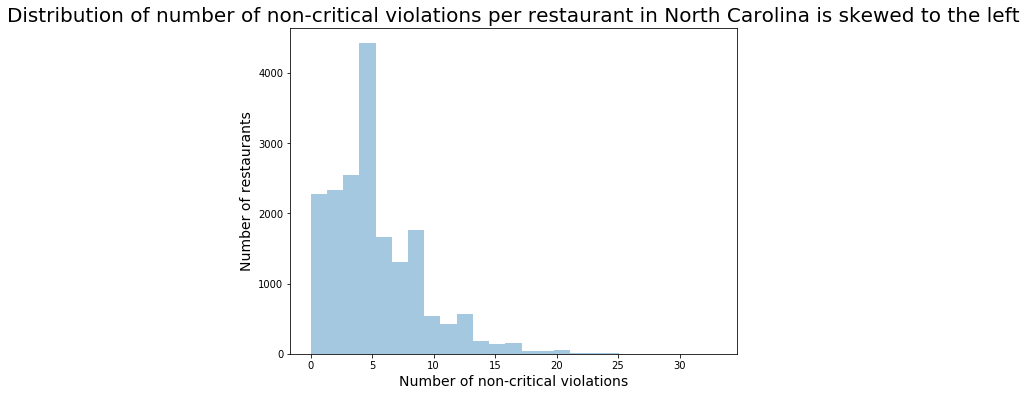

In [12]:
plt.figure(figsize=(8, 6))
graph = sns.distplot(df_inspections['num_non_critical'], bins=25, kde=False);
graph.set_title("Distribution of number of non-critical violations per restaurant in North Carolina is skewed to the left",fontsize=20)
graph.set_xlabel("Number of non-critical violations",fontsize=14);
graph.set_ylabel("Number of restaurants",fontsize=14)
plt.show()

These histograms show that the number of violations follow a similar skewed (though inverted) pattern, with most of the inspections falling within a lower range of violations (they are also not normally distributed). Note that the distribution of number of critical violations matches the distribution of scores more closely, which is expected since the critical violations have a higher impact on the score in the North Carolina system. Since the critical violations are the ones which most significantly affects a restaurant's health and safety conditions, I will focus on them and disregard non critical violations for the rest of the analysis.

### Scores and number of violations per city

Having obtained a general idea of the distribution of scores in the dataset overall, we can start looking at how those numbers change based on the location of the inspected restaurant. We start that analysis by examining patterns when grouping restaurants at the city level.

In [13]:
by_city = df_inspections.groupby('city').mean()
print("Average score of city with highest score is: %f" %by_city['score'].max())
print("Average score of city with lowest score is: %f" %by_city['score'].min())
print("Average score per city: ")
by_city['score']

Average score of city with highest score is: 98.250000
Average score of city with lowest score is: 94.750000
Average score per city: 


city
angier           94.750000
apex             96.305868
cary             96.353045
clayton          97.111111
creedmoor        98.250000
fuquay-varina    95.031757
garner           97.096661
holly springs    95.601253
knightdale       96.453202
morrisville      95.686340
new hill         95.277778
raleigh          96.252911
rolesville       96.795620
wake forest      96.420154
wendell          96.976316
willow spring    95.659091
zebulon          96.482527
Name: score, dtype: float64

The average score per city did not differ much, with the range of averages per city being less than 4 points (out of 100), showing that there is not a significant difference between overall inspection scores between cities.

Repeating the process for number of critical violations:

In [14]:
print("Max average number of critical violations is: %f" %by_city['num_critical'].max())
print("Min average number of critical violations is: %f" %by_city['num_critical'].min())
print("Average number of critical violations per city: ")
by_city['num_critical']

Max average number of critical violations is: 6.000000
Min average number of critical violations is: 0.500000
Average number of critical violations per city: 


city
angier           6.000000
apex             2.997503
cary             3.188666
clayton          1.555556
creedmoor        0.500000
fuquay-varina    4.231081
garner           2.356766
holly springs    3.665971
knightdale       2.413793
morrisville      3.530504
new hill         3.777778
raleigh          2.674787
rolesville       2.124088
wake forest      2.309471
wendell          2.200000
willow spring    3.272727
zebulon          2.395161
Name: num_critical, dtype: float64

The average number of critical violations table showed greater variation, suggesting that there are differences in the overall sanitary conditions of restaurants in each city. For example, restaurants in Angier have on average 12 times more critical violations than restaraunts in Creedmoor, a significant difference. 

However, closer examination of the each of these cities, as shown below, reveals that they each have a very small number of observations, so it's mathematically more likely that they would have outlier values and they do not tell us much about the relationship we investigating.

In [15]:
print("Number of observations in Angier: %d" %df_inspections.loc[df_inspections['city'] == 'angier'].shape[0])

Number of observations in Angier: 6


In [16]:
print("Number of observations in Creedmoor: %d" %df_inspections.loc[df_inspections['city'] == 'creedmoor'].shape[0])

Number of observations in Creedmoor: 2


Given the above realization, it is possible that the variability in number of critical violations could have been simply due to outliers whose averages are less reliable due to their much smaller sample size. To verify this possibility, we can remove cities with too few (less than 100) observations from the dataset, then check the result for the remaining ones.

In [17]:
# First get the count for each city and determine cities to drop
by_city_count = df_inspections.groupby('city').count()['score']
drop_city = []
for key in by_city_count.keys():
    if by_city_count[key] < 100:
        drop_city.append(key)

# Then use list to drop from the dataframe
df_inspections = df_inspections[~df_inspections['city'].isin(drop_city)]

# Repeat previous procedure
by_city = df_inspections.groupby('city').mean()
print("Max average number of critical violations is: %f" %by_city['num_critical'].max())
print("Min average number of critical violations is: %f" %by_city['num_critical'].min())
print("Average number of critical violations per city: ")
by_city['num_critical']

Max average number of critical violations is: 4.231081
Min average number of critical violations is: 2.124088
Average number of critical violations per city: 


city
apex             2.997503
cary             3.188666
fuquay-varina    4.231081
garner           2.356766
holly springs    3.665971
knightdale       2.413793
morrisville      3.530504
raleigh          2.674787
rolesville       2.124088
wake forest      2.309471
wendell          2.200000
zebulon          2.395161
Name: num_critical, dtype: float64

Removing the outliers really narrowed the range of average number of critical violations (from 5.5 to about 1.9), and even amongst the remaining cities there is still a considerable disparity in number of observations, potentially affecting the numbers. However, given that a single critical violation by itself can pose a health/safety hazard, the variation in the table above is sufficient to determine that on average the city in which a restaurant is located does have some relationship, albeit a small one, to its sanitary conditions.

### Predicting score and number of violations based on coordinate location

While the above results were a good starting point, to further investigate the relationship between restaurants' locations and their sanitary conditions, we must move closer than the city level. One way to accomplish this is to look at similarity in results among restaurants that are close together based on their actual geographical proximity, using the X and Y coordinates from the dataset. To do so, we can use K-Nearest Neighbors regression models to predict restaurant scores/number of critical violations, splitting the data into train and test, then use Mean Squared Error on the test predictions to assess the efficiency of the models. K-Nearest Neighbors is a good choice for this task since it works on non-parametric data (such as the one in this dataset).

In [18]:
# First shuffle dataframe in case observations are in some location-related order
df_inspections_shuffled = df_inspections.sample(frac=1)

# Extract relevant columns
X_coords = df_inspections_shuffled['x'].tolist()
Y_coords = df_inspections_shuffled['y'].tolist()
zip_codes = df_inspections_shuffled['zip'].tolist()
scores = df_inspections_shuffled['score'].tolist()
num_critical = df_inspections_shuffled['num_critical'].tolist()

# 80/20 split for train and test
train_len = int(0.8 * len(X_coords))
X_train = X_coords[:train_len]
X_test = X_coords[train_len:]
Y_train = Y_coords[:train_len]
Y_test = Y_coords[train_len:]
zip_train = zip_codes[:train_len]
zip_test = zip_codes[train_len:]
train_score = scores[:train_len]
test_score = scores[train_len:]
train_num_critical = num_critical[:train_len]
test_num_critical = num_critical[train_len:]

# Separating into test and train array
train_array = []
for i in range(0,len(X_train)):
    train_array.append([X_train[i],Y_train[i]])
    
test_array = []
for i in range(0,len(X_test)):
    test_array.append([X_test[i],Y_test[i]])
    
# the 'distance' option gives greatest weight to the closer neighbors,
# helping to ensure that the data points that impact the predictions
# are actually nearby
KNN = KNeighborsRegressor(weights='distance')

# Training, and predicting results
KNN.fit(train_array,train_num_critical)
num_critical_prediction = KNN.predict(test_array)


To evaluate the accuracy of the predictions, we can examine their Mean Squared Error.

In [19]:
print("Mean squared error of predictions for number of critical values: %.3f" %mean_squared_error(test_num_critical,num_critical_prediction))

Mean squared error of predictions for number of critical values: 7.372


Repeating the process for the restaurant scores:

In [20]:
KNN = KNeighborsRegressor(weights='distance')

# Training, predicting, and evaluating results
KNN.fit(train_array,train_score)
score_prediction = KNN.predict(test_array)

print("Mean squared error of predictions for inspection scores: %.3f" %mean_squared_error(test_score,score_prediction))

Mean squared error of predictions for inspection scores: 5.305


To help quantify the performance of the models, we can compare them to semi-random educated predictions, that guess values within the range in which most of the data lies (94-100 for score and 0-10 for number of critical violations)

In [21]:
random_scores = []
for i in range(0,len(test_score)):
    random_scores.append(random.randint(94,100))
    
random_num_critical = []
for i in range(0,len(test_num_critical)):
    random_num_critical.append(random.randint(0,10))

print("Mean squared error of guesses for number of critical violations: %.3f" %mean_squared_error(test_num_critical,random_num_critical))
print("Mean squared error of guesses for inspection scores: %.3f" %mean_squared_error(test_score,random_scores))
    


Mean squared error of guesses for number of critical violations: 22.349
Mean squared error of guesses for inspection scores: 11.521


It can now be observed that the nearest neighbor models considerably outperformed the educated guesses. The difference was more significant for the number of critical violations, as expected given that the range that captures most of its values is larger. This result demonstrates that the sanitary conditions of neighboring restaurants can be reliably used to predict a given restaurant's own sanitary conditions with reasonable accuracy, $\textbf{indicating that nearby restaurants in North Carolina do indeed share similar sanitary conditions}$, as hypothesized. 

Having established that, the next step is to explore whether those similarities are caused by the socio-economic conditions of the restaurants' locations.

### Distribution of income per capita

To start this part of the analysis, it is helpful to again observe general patterns related to the new variable. The histogram below shows its distribution 

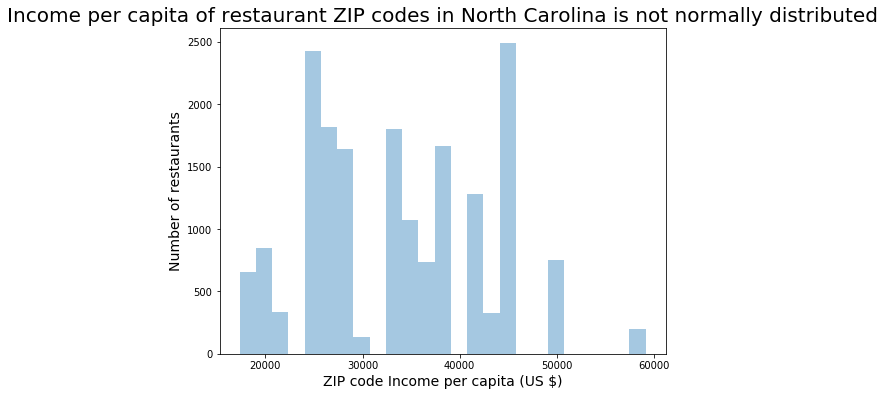

In [22]:
# Joining the datasets
df_joined = df_inspections.set_index('zip').join(other=df_zipcodes.set_index('zip'))
df_joined = df_joined.dropna()
df_joined.head()

plt.figure(figsize=(8, 6))
graph = sns.distplot(df_joined['per_capita_income_dollars'], bins=25, kde=False);
graph.set_title("Income per capita of restaurant ZIP codes in North Carolina is not normally distributed",fontsize=20)
graph.set_xlabel("ZIP code Income per capita (US \$)",fontsize=14);
graph.set_ylabel("Number of restaurants",fontsize=14)
plt.show()

Based on the histogram above, we can see that income per capita is not as skewed as the inspection-related metrics. However, it appears somewhat bi-modal and does not look normally distributed.

Plotting income per capita of zip codes against the inspection-related metrics of restaurants will help determine any potential relationships between them.

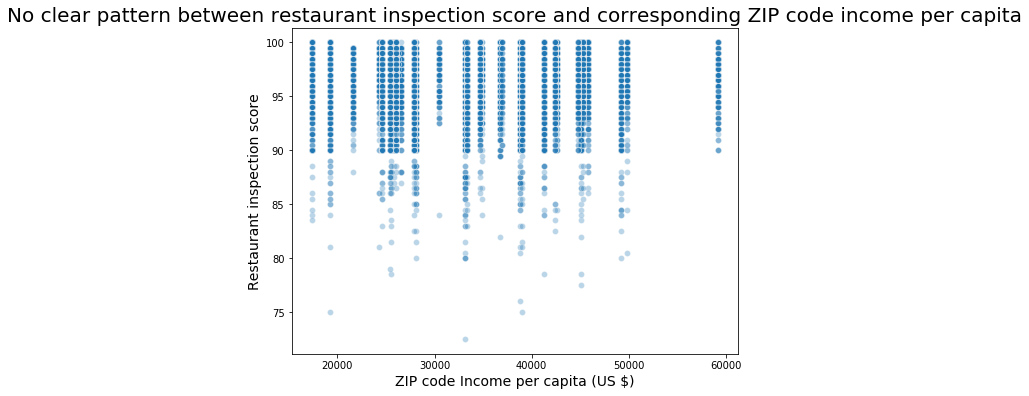

In [23]:
plt.figure(figsize=(8, 6))
graph = sns.scatterplot(x='per_capita_income_dollars',y='score',data=df_joined, alpha=0.3);
graph.set_title("No clear pattern between restaurant inspection score and corresponding ZIP code income per capita",fontsize=20)
graph.set_xlabel("ZIP code Income per capita (US \$)",fontsize=14);
graph.set_ylabel("Restaurant inspection score",fontsize=14)
plt.show()

The above plot does not demonstrate any meaningful relationship between the variables, seen as most of the points on the graph are in the above 90 range and the ones that fall below seem randomly spread across different income per capita values.

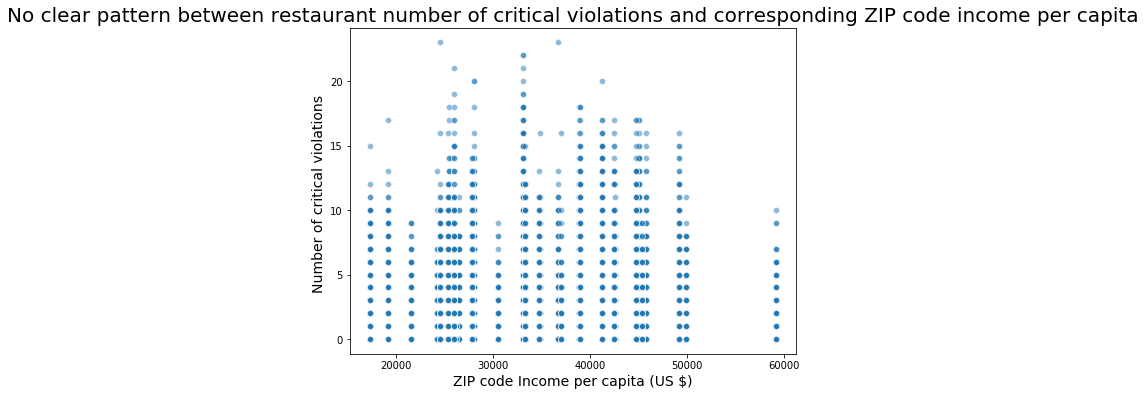

In [24]:
plt.figure(figsize=(8, 6))
graph = sns.scatterplot(x='per_capita_income_dollars',y='num_critical',data=df_joined, alpha=0.5);
graph.set_title("No clear pattern between restaurant number of critical violations and corresponding ZIP code income per capita",fontsize=20)
graph.set_xlabel("ZIP code Income per capita (US \$)",fontsize=14);
graph.set_ylabel("Number of critical violations ",fontsize=14)
plt.show()

While at first glance the above plot might look slightly parabolic, with the higher values towards the middle, referring back to the histogram of per capita income shows that the plot more or less follows its shape. It is natural to expect that there would be more outliers in the range of income per capita that has more observations, so this scatter plot similarly does not show any meaningful relationships. 

The scatter plots did not demonstrate any relationships, though they were not very easy to visualize due to the sheer number of points and the overlap between them. To address that problem, we can instead use a scatter plot to observe average values of inspections by income per capita.  

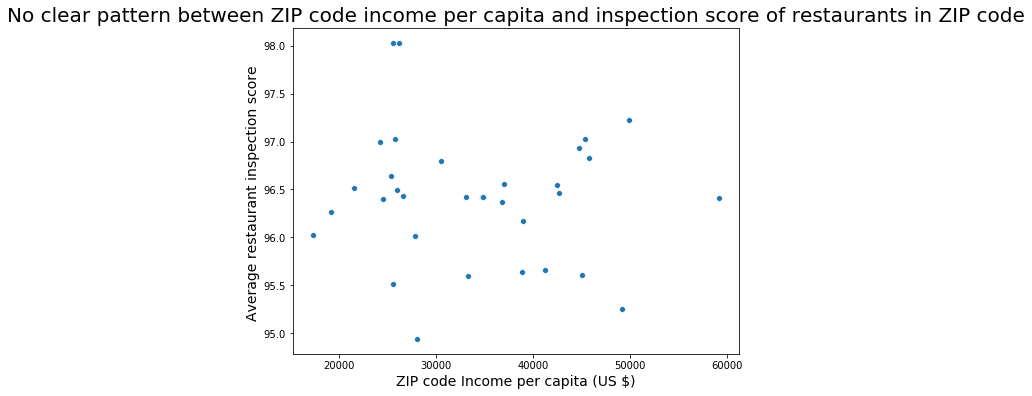

In [25]:
by_income = df_joined.groupby('per_capita_income_dollars').mean()
plt.figure(figsize=(8, 6))
graph = sns.scatterplot(x='per_capita_income_dollars',y='score',data=by_income.reset_index());
graph.set_title("No clear pattern between ZIP code income per capita and inspection score of restaurants in ZIP code",fontsize=20)
graph.set_xlabel("ZIP code Income per capita (US \$)",fontsize=14);
graph.set_ylabel("Average restaurant inspection score ",fontsize=14)
plt.show()

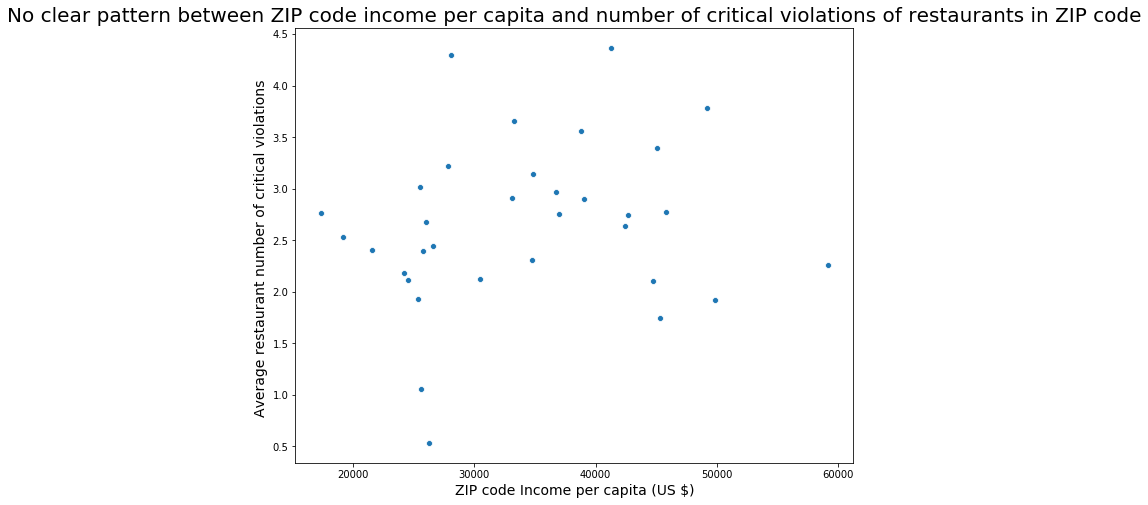

In [26]:
plt.figure(figsize=(10, 8))
graph = sns.scatterplot(x='per_capita_income_dollars',y='num_critical',data=by_income.reset_index());
graph.set_title("No clear pattern between ZIP code income per capita and number of critical violations of restaurants in ZIP code",fontsize=20)
graph.set_xlabel("ZIP code Income per capita (US \$)",fontsize=14);
graph.set_ylabel("Average restaurant number of critical violations ",fontsize=14)
plt.show()

As shown above, plotting averages seemed to corroborate the initial impression that there is no relationship between the income per capita of a particular zip code and the sanitary conditions of restaurants in said zip code.

However, we can make use of a more involved statistical test to further investigate if there is indeed no relationship between the aforementioned variables.

### Mann-Whitney U Test

The Mann-Whitney U test is useful in this situation because it works even if the related variables are not normally distributed, which, as previously discussed, is the case for my data. I will perform the test across several groups of scores/number of critical violations from areas with different income per capita values, then use that information to deduce whether said income per capita values affect the underlying distributions.

For the following tests, the null hypothesis will be that each pair of scores and pair of number of critical violations come from the same underlying distribution, with the alternative being that they come from different distributions (indicating that the income per capita affects the distribution). The alpha value used will be 5%.

In [29]:
# Splitting dataset more or less along the middle based on income per capita
# values were chosen so that each group was about the same size
over_35 = df_joined[df_joined['per_capita_income_dollars'] >= 35000]
over_35_scores = over_35['score']
over_35_num_critical = over_35['num_critical']

under_30 = df_joined[df_joined['per_capita_income_dollars'] <= 30000]
under_30_scores = under_30['score']
under_30_num_critical = under_30['num_critical']

# Carrying out test
_, p_score = mannwhitneyu(list(over_35_scores), list(under_30_scores))
_, p_num_crit = mannwhitneyu(list(over_35_num_critical), list(under_30_num_critical))

print("P value of test for inspection scores: %.3f" %p_score)
print("P value of test for number of critical violations: %.3f" %p_num_crit)

P value of test for inspection scores: 0.123
P value of test for number of critical violations: 0.033


For the above tests, we fail to reject the null hypothesis for the scores test, but we are able to reject the null for the number of critical violations test, suggesting that the number of critical violations per restaurant of each group comes from different underlying distribution. This seems to indicate that the income per capita of a zip code is related to the number of critical violations of restaurants in that zip code.

Let us repeat the test using different values to generate the groups:

In [30]:
# Splitting dataset into groups of extreme values of income per capita
# values were chosen so that each group was more or less the same size
over_50 = df_joined[df_joined['per_capita_income_dollars'] >= 50000]
over_50_scores = over_50['score']
over_50_num_critical = over_50['num_critical']

under_18 = df_joined[df_joined['per_capita_income_dollars'] <= 18000]
under_18_scores = under_18['score']
under_18_num_critical = under_18['num_critical']

# Carrying out test
_, p_score = mannwhitneyu(list(over_50_scores), list(under_18_scores))
_, p_num_crit = mannwhitneyu(list(over_50_num_critical), list(under_18_num_critical))

print("P value of test for inspection scores: %.3f" %p_score)
print("P value of test for number of critical violations: %.3f" %p_num_crit)

P value of test for inspection scores: 0.020
P value of test for number of critical violations: 0.006


When separating scores by more extreme values, we reject the null hypothesis in both tests, allowing us to conclude that the number of critical violations per restaurant from each group and the inspection scores from each group most likely came from different underlying distrubtions, again indicating some relationship between income per capita of a zip code and overall sanitary conditions of restaurants in that zip code.

Therefore, the Mann Whitney U Test demonstrated that, despite the initial impression after plotting the variables against each other, $\textbf{there is some relationship between income per capita of a zip code and overall sanitary conditions of restaurants in that zip code}$. However, the lack of concrete, interpretable correlation between the related variables demonstrates that $\textbf{the income per capita of a zip code does not seem to have any causal impact on the sanitary conditions of restaurants in that zip code}$, unlike what was originally hypothesized.

# Ethics & Privacy

All of the data about the inspection results are publicly available and restaurants are mandated by law to display their health inspection letter grade to customers; therefore, there is no privacy concern in using and displaying said data. Nevertheless, since the purpose of the project is to look at general trends by location and not specific cases, all information specific to a particular restaurant, including name and phone number, was omitted. Additionally, the inspection data has information about which health inspector conducted the inspection; this was also removed for additional privacy since it did not pertain to the analysis.

A potential ethical concern would be to accidentally demonstrate a clear correlation between specific regions and worse health and safety conditions of restaurants around the area. This would have the risk of creating biases about the area and the restaurants within it, which could potentially unfairly hurt its local businesses, including ones with adequate health and safety conditions. The problem could be even worse if such a correlation was found in an area with a demographic mainly composed of ethnic minorities, as it could accidentally help propagate harmful racial stereotypes. To address this, I avoided focusing on the sanitary conditions of very specific areas (besides cities, which are not as problematic since they define a larger and more heterogenic space), preferring to work with general patterns instead. Additionally, I made sure to remove the "percent non-white" field from the ZIP code dataset, since it did not pertain to my analysis at all and could lead to unintended, potentially problematic conclusions.

Ultimately, while I took steps in advance to handle potential ethical concerns related to my study, the fact that the vast majority of restaurants in every properly sampled location had good inspection results effectively extinguished any possible remaining ethical concerns.

# Conclusion & Discussion

In this project, I aimed to investigate whether nearby restaurants in North Carolina shared similar sanitary conditions, and whether such trend is caused by the socio-economic conditions of said locations. To answer this question, I used a dataset with results of tens of thousands of inspections throughout the state and a dataset with socio-economic indicators of zip codes in the state. The data did not follow any recognizable distributions, so the methods used for analysis were mostly non-parametric.

After training a K-Nearest Neighbors regression model that used a restaurant's geographical coordinates for prediction and ascertaining that it performed with reasonable accuracy, I could conclude that nearby restaurants in North Carolina do in fact share similar sanitary conditions, as initially hypothesized. The answer to the second part of my investigation, however, was not as clear. A Mann Whitney U Test demonstrated that health and safety indicators (inspections scores and number of critical violations) of groups of restaurants located in ZIP codes with dramatic difference in income per capita came from different underlying distributions. However, the lack of relationship between these variables lead me to conclude that it was not the income per capita of the zip codes that were driving these differences in the distributions, unlike originally hypothesized.

However, for both parts of the conclusion, there is the underlying limitation, which was hinted at in the beginning of the analysis, that the inspection results in general were very skewed, with very good results overall and very little variance. This reduces the significance of both the above conclusions, since if virtually every restaurant in our dataset shares reasonably similar inspection results: 
- It follows somewhat trivially that nearby restaurants will also share similar results.
- There is not much variance in the results for socio-economic indicators to drive. 

Another (less serious) limitation was that there were no socio-economic data for several ZIP codes in the inspections datasets.

Ultimately, while perhaps not the most interesting for analysis, the results of my investigation are encouraging since they show that any restaurant in North Carolina has the capacity to maintain good health and safety standards, regardless of the wealthiness of their surroundings. If I were to conduct further research on restaurant inspections in the state, I would choose to investigate foodborne illnesses to determine to what extent these high inspections scores are reliable health and safety indicators.